In [1]:
# ==============================================================================
# Import Libraries
# ==============================================================================
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.activations import swish
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# ==============================================================================
# Loading Data
# ==============================================================================
df = pd.read_excel('Volve production data.xlsx', sheet_name='Daily Production Data')

In [3]:
# ==============================================================================
# Grouping & Aggregation
# ==============================================================================
df_combined = df.groupby(df.columns[0], as_index=False)[df.columns[18]].sum()
df_combined['DATEPRD'] = range(0, len(df_combined))
df_combined = df_combined.set_index('DATEPRD')


In [4]:
# ==============================================================================
# Data Truncation
# ==============================================================================
rows_to_keep = len(df_combined) - 164 - 43
df_combined = df_combined.iloc[164:164+rows_to_keep]
oil_col = df_combined.columns[0]

In [5]:
# ==============================================================================
# Exponential Weighted Moving Average
# ==============================================================================
df_combined['oil_smooth'] = df_combined[oil_col].ewm(alpha=0.1, adjust=False).mean()

oil_original_sum = df_combined[oil_col].sum()
oil_smoothed_sum = df_combined['oil_smooth'].sum()

oil_adjustment_factor = oil_original_sum / oil_smoothed_sum

df_combined['oil_adjusted'] = df_combined['oil_smooth'] * oil_adjustment_factor

In [6]:
# ==============================================================================
# Data Selection
# ==============================================================================
df_combined = df_combined[['oil_adjusted']]


In [7]:
# ==============================================================================
# Index Adjustment
# ==============================================================================
df_combined.index = range(0, len(df_combined))

In [8]:
# ==============================================================================
# Preprocessing
# ==============================================================================
def preprocess_data(data, look_back = 7, forward_steps = 7):
    sc = MinMaxScaler(feature_range=(0, 1))
    data_scaled = sc.fit_transform(data)
    X, Y = [], []
    for i in range(0, len(data_scaled) - look_back - forward_steps + 1, look_back):
        X.append(data_scaled[i:(i + look_back), 0])
        Y.append(data_scaled[i + look_back:i + look_back + forward_steps, 0])
    return np.array(X), np.array(Y), sc

look_back = 7
forward_steps = 7

split_idx = int(len(df_combined) * 0.65)
data_train_val = df_combined.iloc[:split_idx]
data_test = df_combined.iloc[split_idx:]
X_train_val, y_train_val, scaler_train_val = preprocess_data(data_train_val.values.reshape(-1, 1))
X_test, y_test, scaler_test = preprocess_data(data_test.values.reshape(-1, 1))

In [9]:
# ==============================================================================
# Model Creation and Compilation
# ==============================================================================
def create_model(input_shape, output_steps):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(500, activation='swish', return_sequences=True),
        Dropout(0.2),
        LSTM(500, activation='swish'),
        Dropout(0.2),
        Dense(output_steps)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

model = create_model((look_back, 1), forward_steps)

In [10]:
# ==============================================================================
# Model Summary
# ==============================================================================
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 500)         │     1,004,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 500)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 500)            │     2,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         3,507 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009,507 (11.48 MB)

 Trainable params: 3,009,507 (11.48 MB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
# ==============================================================================
# Model Training
# ==============================================================================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_val, y_train_val, validation_split=0.2, epochs=25, batch_size=1, callbacks=[early_stop])

Epoch 1/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.2184 - val_loss: 0.0265
Epoch 2/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0786 - val_loss: 0.0306
Epoch 3/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0628 - val_loss: 0.0424
Epoch 4/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0694 - val_loss: 0.0301
Epoch 5/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0585 - val_loss: 0.0258
Epoch 6/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0599 - val_loss: 0.0209
Epoch 7/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0623 - val_loss: 0.0239
Epoch 8/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0642 - val_loss: 0.0646
Epoch 9/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0604 - val_loss: 0.0246
Epoch 10/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0648 - val_loss: 0.0205
Epoch 11/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0618 - val_loss: 0.0393
Epoch 12/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 

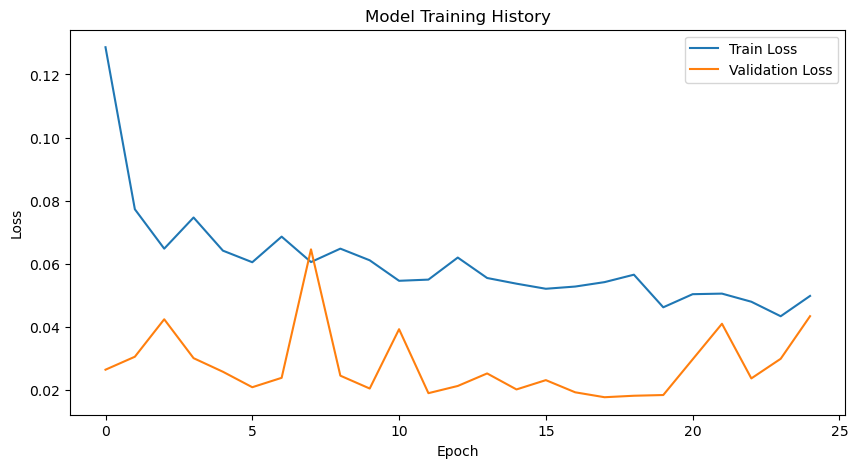

In [12]:
# ==============================================================================
# Plotting Training and Validation Loss History
# ==============================================================================
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [21]:
# ==============================================================================
# Prediction
# ==============================================================================
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [22]:
# ==============================================================================
# Post-processing
# ==============================================================================
y_pred = scaler_test.inverse_transform(y_pred)
y_actual = scaler_test.inverse_transform(y_test.reshape(-1, forward_steps))

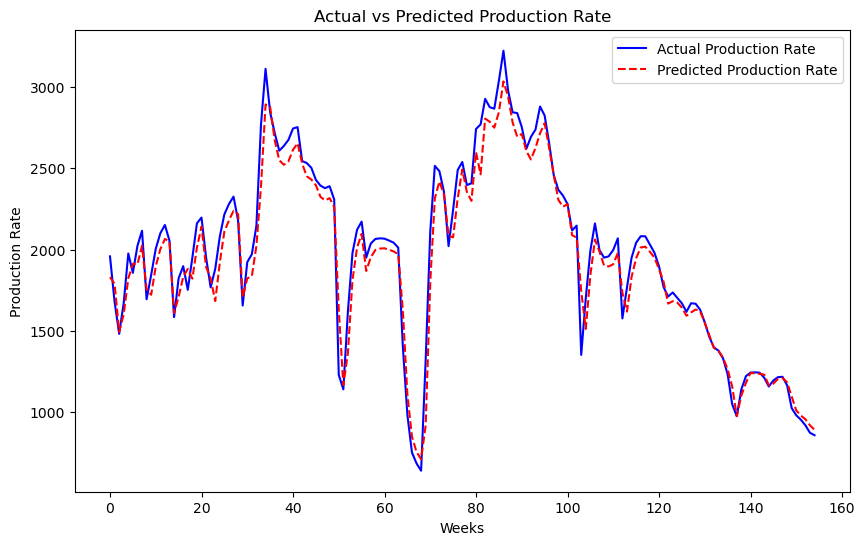

In [24]:
# ==============================================================================
# Plotting Actual vs Predicted Values
# ==============================================================================
plt.figure(figsize=(10, 6))
plt.plot(y_actual[:, 0], label='Actual Production Rate', color='blue')
plt.plot(y_pred[:, 0], label='Predicted Production Rate', color='red', linestyle='--')
plt.title('Actual vs Predicted Production Rate')
plt.xlabel('Weeks')
plt.ylabel('Production Rate')
plt.legend()
plt.show()

In [16]:
# ==============================================================================
# Filtering Non-Zero Values
# ==============================================================================
non_zero_indices = np.where(y_actual != 0)
actual_filtered = y_actual[non_zero_indices]
predicted_filtered = y_pred[non_zero_indices]

In [17]:
# ==============================================================================
# Calculating Mean Absolute Percentage Error (MAPE)
# ==============================================================================
mape = np.mean(np.abs((actual_filtered - predicted_filtered) / actual_filtered)) * 100
print(f'Mean Absolute Percentage Error (MAPE) for all forecast steps (excluding zeros): {mape:.4f}%')

Mean Absolute Percentage Error (MAPE) for all forecast steps (excluding zeros): 7.6760%


In [18]:
# ==============================================================================
# Calculating Mean Absolute Error (MAE)
# ==============================================================================
mae = np.mean(np.abs(actual_filtered - predicted_filtered))
print(f'Mean Absolute Error (MAE) for all forecast steps (excluding zeros): {mae:.4f}')

Mean Absolute Error (MAE) for all forecast steps (excluding zeros): 143.9785


In [19]:
# ==============================================================================
# Calculating R-squared (R2)
# ==============================================================================
ss_res = np.sum((actual_filtered - predicted_filtered) ** 2)
ss_tot = np.sum((actual_filtered - np.mean(actual_filtered)) ** 2)
r2 = 1 - (ss_res / ss_tot)
print(f'R-squared (R2) for all forecast steps (excluding zeros): {r2:.4f}')

R-squared (R2) for all forecast steps (excluding zeros): 0.8768


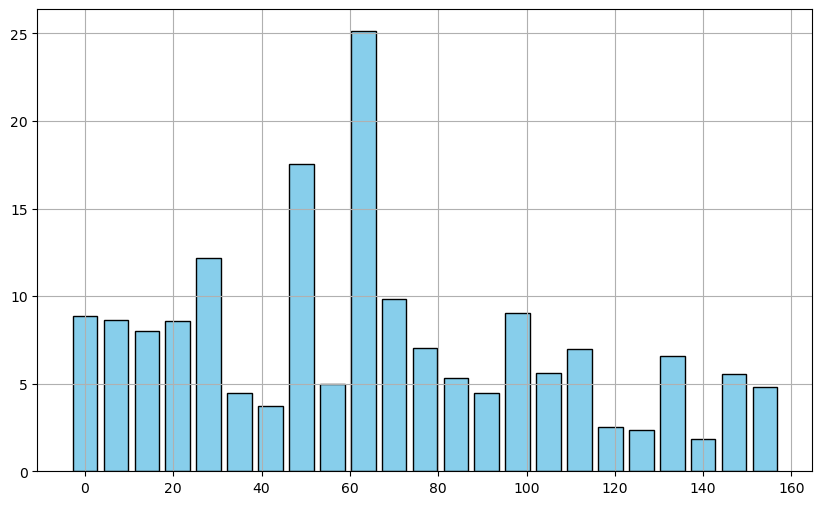

In [23]:
# ==============================================================================
# Plotting the Mean Absolute Percentage Error (MAPE) Values
# ==============================================================================
step_size = 7
mapes = []
chunks = []

for start_index in range(0, len(y_actual), step_size):
    end_index = start_index + step_size
    actual_range = y_actual[start_index:end_index]
    predicted_range = y_pred[start_index:end_index]
    
    if not np.any(actual_range == 0):
        mape = np.mean(np.abs((actual_range - predicted_range) / actual_range)) * 100
        mapes.append(mape)
        chunks.append(start_index)

plt.figure(figsize=(10, 6))
plt.bar(chunks, mapes, width=step_size*0.8, color='skyblue', edgecolor='black')
plt.grid(True)
plt.show()